In [24]:
import os
import pandas as pd
import numpy as np
import math
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from parse import *
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier as RandomForest
import random
from sklearn import linear_model
from datetime import datetime
import gc

pd.set_option("display.max_columns", 2000)


In [25]:
CHUNKSIZE = 100000

TRAIN_DATE        = "train_date.csv"
TRAIN_NUMERIC     = "train_numeric.csv"
TRAIN_CATEGORICAL = "train_categorical.csv"
TEST_DATE         = "test_date.csv"
TEST_NUMERIC      = "test_numeric.csv"
TEST_CATEGORICAL  = "test_categorical.csv"

SEED = 0
CHUNKSIZE = 50000
NROWS = 1200000

ID_COLUMN = 'Id'
TARGET_COLUMN = 'Response'
 

In [26]:
df = pd.read_csv("../output/df_id_response.csv")
X_pre = pd.read_csv("../from/train_cat_int_sub_miya.csv").drop('Id', axis=1)

In [27]:
print (df.head())
print (X_pre.head())

     Id  Response
0   4.0       0.0
1   6.0       0.0
2   7.0       0.0
3   9.0       0.0
4  11.0       0.0
   L3_S32_F3854  L3_S35_F3899
0             0             0
1             0             0
2             0             0
3             0             0
4             0             0


In [28]:
from sklearn.model_selection import train_test_split

start = datetime.now()

## 教師データと訓練データに分離
y = df['Response']
X = X_pre

## テストセットと訓練セットに分離
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print(X_train.head())
print(y_train.head())

print(X_test.head())
print(y_test.head())

print("{} -> {}".format(start, datetime.now()))

         L3_S32_F3854  L3_S35_F3899
1167472             0             0
257884              0             0
499721              0             0
200055              0             0
777330              0             0
1167472    0.0
257884     0.0
499721     0.0
200055     0.0
777330     0.0
Name: Response, dtype: float64
        L3_S32_F3854  L3_S35_F3899
139214             0             0
664500             0             0
140448             0             0
250441             0             0
322956             0             0
139214    0.0
664500    0.0
140448    0.0
250441    0.0
322956    0.0
Name: Response, dtype: float64
2018-07-15 16:20:39.330355 -> 2018-07-15 16:20:39.455299


In [29]:
## 学習
import lightgbm as lgb

start = datetime.now()

clf = lgb.LGBMClassifier(metric='binary_log_loss', objective='binary', is_unbalanced=True, boosting_type='dart')
clf.fit(X_train, y_train)
print(X_train.shape)
print("{} -> {}".format(start, datetime.now()))

(793110, 2)
2018-07-15 16:20:45.768410 -> 2018-07-15 16:20:50.830694


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[0. 0. 0. ... 0. 0. 0.]
[0.01177729 0.01177729 0.01177729 ... 0.01177729 0.01177729 0.01177729]
matthews_corrcoef = [0.00053573 0.11974218 0.11974218 0.13388197 0.13613926 0.13613926
 0.13613926 0.13613926 0.13613926 0.06495624 0.06350837 0.06350837
 0.06350837 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
best threshold = 0.09


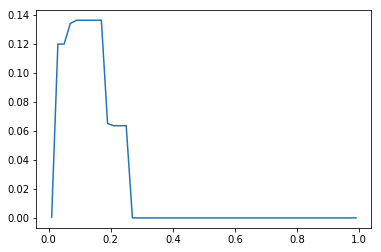

In [30]:
from sklearn import metrics
import matplotlib.pyplot as plt

start = datetime.now()

thresholds = np.linspace(0.01,0.99,50)
y_pred = clf.predict_proba(X_test.values)[:,1]
mcc = np.array([metrics.matthews_corrcoef(y_test.values, y_pred>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
print(y_test.values)
print(y_pred)
print("matthews_corrcoef = {}".format(mcc))
df_pred = pd.DataFrame({'Response':y_pred})
best_thr = thresholds[mcc.argmax()]
print("best threshold = {}".format(best_thr))

In [31]:
start = datetime.now()

#特徴量重要度を表示
for i in range(0, X_train.shape[1]):
    if 0 < clf.feature_importances_[i]:
        print("{}:{}".format(X_train.columns[i], clf.feature_importances_[i]))
print("{} -> {}".format(start, datetime.now()))

L3_S32_F3854:1559
L3_S35_F3899:100
2018-07-15 16:21:14.079109 -> 2018-07-15 16:21:14.079109


In [32]:
start = datetime.now()

#全訓練データを用いて再学習
clf.fit(X, y)
print("{} -> {}".format(start, datetime.now()))

2018-07-15 16:21:15.626293 -> 2018-07-15 16:21:23.205648


In [33]:
start = datetime.now()
#取得
X_test = pd.read_csv("../from/test_cat_int_sub_miya.csv")
X_test_pre = X_test.drop('Id', axis=1)
X_test_id = X_test.Id

##予測
ary_test_pred = clf.predict(X_test_pre.values)
df_test_pred = pd.DataFrame({'Id':X_test_id.values, 'Response':ary_test_pred})

df_test_pred['Response'] = df_test_pred.Response.astype('bool')
df_test_pred.head()

C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,Id,Response
0,1,False
1,2,False
2,3,False
3,5,False
4,8,False


In [34]:
ary_test_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [35]:
##CSV出力
y_submit = df_test_pred
type(y_submit)
y_submit.to_csv("submit_cat_miya.csv", columns=['Id', 'Response'], index=False)

In [36]:
y_submit.Response.sum()

0